In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
import genomeview
from pybedtools import BedTool
from plotting_utils import figure_path
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
from matplotlib import rcParams
from peak_utils import *
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
peak_path = project_path + '/merged_bed/MACS2/annotated'
peak_tsv = peak_path + '/unfragmented.annotated_peaks.tsv'
peak_df = pd.read_table(peak_tsv) 
peak_df.head()

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,sense_gname,sense_gtype,antisense_gname,antisense_gtype
0,chr5,140090856,140091005,unfragmented.fwd_peak_2108,944802,+,16330.81055,94487.18750,94480.20312,25782.0,"VTRNA1-1,VTRNA1-1","misc_RNA,vault_RNA",NaN,NaN
1,chr14,50329265,50329578,unfragmented.rvs_peak_6254,797100,-,14712.14648,79717.42188,79710.09375,24211.0,7SLRNA,srpRNA,NaN,NaN
2,chr14,50053028,50053619,unfragmented.fwd_peak_743,382149,+,7339.72070,38221.47656,38214.96875,14409.0,7SLRNA,srpRNA,"NCBP2,GEMIN5","RBP,RBP"
3,chr1,28975111,28975246,unfragmented.fwd_peak_53,119618,+,2297.73364,11968.23242,11961.88867,4467.0,RNU11,snRNA,NaN,NaN
4,chr5,140098506,140098621,unfragmented.fwd_peak_2109,56467,+,1220.64233,5652.99072,5646.74316,1744.0,"VTRNA1-2,VTRNA1-2","misc_RNA,vault_RNA",NaN,NaN


In [6]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(123)
colors = random.sample(colors, k = len(peak_df.merged_type.unique()))
ce.fit(peak_df.merged_type, colors)

In [8]:
peak_df\
        .assign(peak_count = 1)\
        .groupby(['merged_type', 'pileup'], as_index=False)\
        .agg({'peak_count':'sum'}) \
        .sort_values('pileup')\
        .reset_index() \
        .assign(cum_count = lambda d: d.groupby('merged_type').peak_count.cumsum())\
        .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
        .query('merged_type == "Long RNA"')

,index,merged_type,pileup,peak_count,cum_count,log_pile
0,0,Long RNA,1.0,4307,4307,0.000000
16,1,Long RNA,2.0,970,5277,0.301030
26,2,Long RNA,3.0,160,5437,0.477121
36,3,Long RNA,4.0,43,5480,0.602060
42,4,Long RNA,5.0,26,5506,0.698970
47,5,Long RNA,6.0,8,5514,0.778151
56,6,Long RNA,7.0,16,5530,0.845098
65,7,Long RNA,8.0,7,5537,0.903090
77,8,Long RNA,9.0,5,5542,0.954243
85,9,Long RNA,10.0,4,5546,1.000000


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_figure.pdf


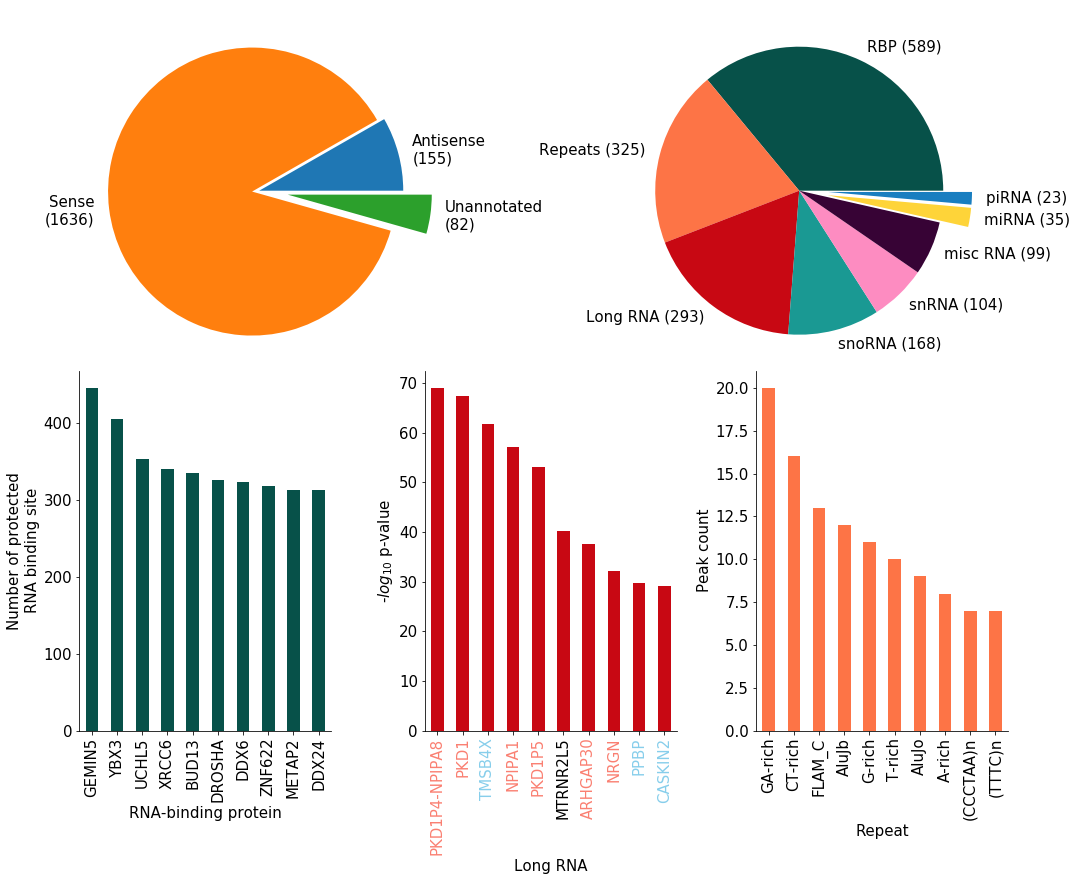

In [13]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.5, 0.5])
pie_ax = fig.add_axes([0.65, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_misc(sense_peaks, misc_ax, ce)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce)
plot_long_RNA_peak(peak_df, long_ax, ce)
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [20]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

In [24]:
peak_df.columns

Index(['chrom', 'start', 'end', 'peakname', 'score', 'strand', 'fc', 'log10p',
       'log10q', 'pileup', 'gname', 'gstrand', 'gtype', 'gid',
       'picked_RNA_anti', 'picked_type_anti', 'picked_RNA_sense',
       'picked_type_sense', 'pvalue', 'merged_type', 'FDR', 'is_sense'],
      dtype='object')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


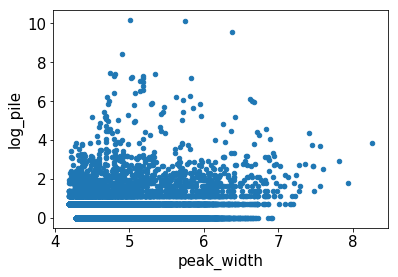

In [26]:
peak_df\
    .assign(peak_width = lambda d: np.log(d.end-d.start))\
    .assign(log_pile = lambda d: d.pileup.transform(np.log))\
    .plot.scatter('peak_width','log_pile')

In [27]:
peak_df\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log))\
    .sort_values('peak_width', ascending=False)

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense,peak_width,log_pile
263,chr15,65243491,65247384,unfragmented.rvs_peak_7130,185,-,7.81245,22.94410,18.56807,47.0,...,(TTC)n,Simple_repeat,(TTC)n,Simple_repeat,1.137365e-23,Repeats,1.111278e-21,Sense,3893,3.850148
1567,chr17,79477011,79479828,unfragmented.rvs_peak_8998,31,-,2.96512,7.10568,3.12706,6.0,...,GC_rich,Low_complexity,AC139149.1,miRNA,7.840071e-08,miRNA,6.688093e-07,Sense,2817,1.791759
362,chr7,5566781,5569265,unfragmented.rvs_peak_19052,125,-,6.54077,17.20884,12.53461,18.0,...,(A)n,Simple_repeat,AC006483.1,miRNA,6.182441e-18,miRNA,4.427605e-16,Sense,2484,2.890372
464,chr6,74227237,74229228,unfragmented.rvs_peak_18218,96,-,5.38594,14.20956,9.67542,12.0,...,.,.,RPS5,protein_coding,6.172200e-15,Long RNA,3.473746e-13,Sense,1991,2.484907
208,chr4,74851982,74853912,unfragmented.rvs_peak_15401,248,-,10.12968,29.71188,24.85138,39.0,...,MIRb,SINE,PPBP,protein_coding,1.941422e-30,Long RNA,2.429829e-28,Sense,1930,3.663562
4492,chr2,192699386,192701315,unfragmented.rvs_peak_11755,26,-,2.77319,6.66566,2.66938,5.0,...,AT_rich,Low_complexity,PUM2,RBP,2.159434e-07,RBP,1.345558e-06,Sense,1929,1.609438
4976,chr12,125396309,125398087,unfragmented.rvs_peak_5315,23,-,2.62170,6.18573,2.35014,4.0,...,.,.,ZNF622,RBP,6.520336e-07,RBP,3.453032e-06,Sense,1778,1.386294
489,chr9,135894808,135896561,unfragmented.fwd_peak_2691,90,+,5.36261,13.63806,9.06974,14.0,...,(TAA)n,Simple_repeat,SNORD141A,snoRNA,2.301124e-14,snoRNA,1.229277e-12,Sense,1753,2.639057
712,chr7,22549930,22551681,unfragmented.rvs_peak_19178,60,-,4.05031,10.23191,6.07022,14.0,...,.,.,piR-hsa-20701,piRNA,5.862596e-11,piRNA,2.073844e-09,Sense,1751,2.639057
202,chr5,10015,11734,unfragmented.fwd_peak_1999,258,+,15.49465,30.99507,25.86660,42.0,...,.,.,(CCCTAA)n,Simple_repeat,1.011416e-31,Repeats,1.309510e-29,Sense,1719,3.737670


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_qc.pdf


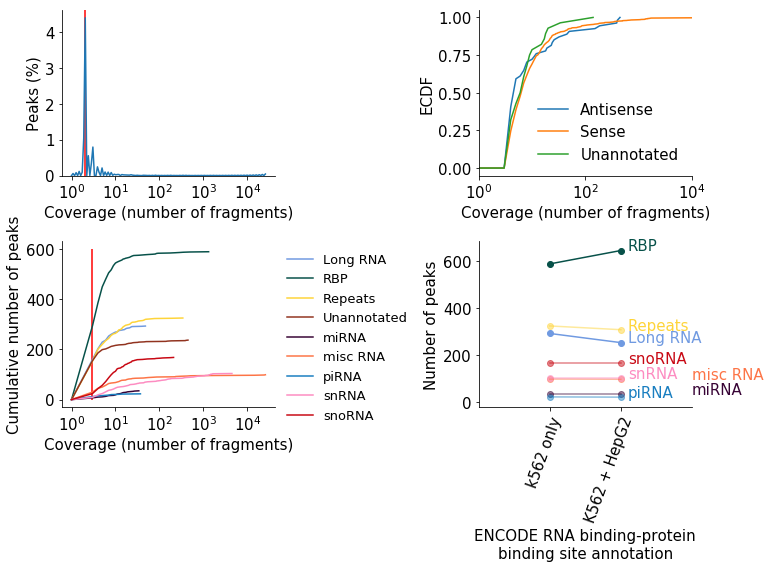

In [80]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax)
#### add hepG2
combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)



In [84]:
lR_peak = peak_df[peak_df.merged_type.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense
96,chr16,16468913,16469003,unfragmented.fwd_peak_916,634,+,23.55909,69.00220,63.47155,23.0,...,unprocessed_pseudogene,ENSG00000227827.3_4,.,.,RP11-958N24.2,unprocessed_pseudogene,9.949471e-70,Long RNA,2.695896e-67,Sense
99,chr16,2149771,2149861,unfragmented.rvs_peak_7526,619,-,22.23985,67.36868,61.94421,22.0,...,"protein_coding,protein_coding,protein_coding","NM_000296.3,NM_001009944.2,ENSG00000008710.19_3",.,.,PKD1,protein_coding,4.278780e-68,Long RNA,1.113457e-65,Sense
109,chr1,42965448,42965982,unfragmented.rvs_peak_434,570,-,18.70778,61.79586,57.04602,48.0,...,"processed_pseudogene,protein_coding","ENSG00000236876.3_3,ENSG00000186409.15_4",CCDC30,protein_coding,RP11-163G10.3,processed_pseudogene,1.600074e-62,Long RNA,3.823158e-60,Sense
114,chr16,15027133,15027223,unfragmented.fwd_peak_911,515,+,21.05987,57.01128,51.57395,21.0,...,"transcribed_unprocessed_pseudogene,protein_coding","ENSG00000183458.13_4,ENSG00000183426.16_3",.,.,NPIPA1,protein_coding,9.743612e-58,Long RNA,2.226881e-55,Sense
122,chr16,18470719,18470809,unfragmented.rvs_peak_7673,477,-,18.63194,53.13421,47.79390,18.0,...,"protein_coding,transcribed_unprocessed_pseudogene","ENSG00000233024.3,ENSG00000254681.6_2",.,.,RP11-1212A22.4,protein_coding,7.341588e-54,Long RNA,1.568772e-51,Sense
159,chr10,57359062,57359245,unfragmented.fwd_peak_288,349,+,13.76813,40.26464,34.97709,17.0,...,"protein_coding,protein_coding,protein_coding","ENSG00000249860.3_2,NM_001190478.1,ENSG0000015...",PCDH15,protein_coding,MTRNR2L5,protein_coding,5.437008e-41,Long RNA,8.987477e-39,Sense
167,chr1,161022152,161022229,unfragmented.rvs_peak_1325,324,-,12.68539,37.61381,32.43976,12.0,...,"protein_coding,protein_coding,protein_coding,p...","NM_001025598.1,NM_001287600.1,NM_001287602.1,N...",.,.,ARHGAP30,protein_coding,2.433268e-38,Long RNA,3.806761e-36,Sense
195,chr11,124609836,124609987,unfragmented.fwd_peak_493,269,+,11.06114,32.05667,26.91813,15.0,...,"protein_coding,protein_coding,protein_coding","ENSG00000154146.12_2,NM_001126181.1,NM_006176.2",.,.,NRGN,protein_coding,8.776675e-33,Long RNA,1.182961e-30,Sense
208,chr4,74851982,74853912,unfragmented.rvs_peak_15401,248,-,10.12968,29.71188,24.85138,39.0,...,"SINE,protein_coding,protein_coding,SINE","MIR,NM_002704.3,ENSG00000163736.3_2,MIR",MIRb,SINE,PPBP,protein_coding,1.941422e-30,Long RNA,2.429829e-28,Sense
213,chr17,73500561,73500652,unfragmented.rvs_peak_8947,239,-,10.68563,29.03766,23.93905,10.0,...,"protein_coding,protein_coding","NM_020753.4,ENSG00000177303.9_4",.,.,CASKIN2,protein_coding,9.169381e-30,Long RNA,1.126163e-27,Sense


In [86]:
def possible_peak(row):
    return ','.join(set(row['gtype'].split(',')))

peak_df\
    .query('is_sense == "Antisense"')\
    .assign(possible = lambda d: [possible_peak(row) for i, row in d.iterrows()]) \
    .pipe(lambda d: d[d.possible.str.contains('protein_coding')]) \
    .pipe(lambda d: d[~d.gname.str.contains('^HB[A-Z]')])\
    .filter('chrom|start|end|picked_RNA_sense|merged_type|pileup|strand|log10p|is_sense'.split('|')) \
    .query('pileup >= %i' %(pileup_cutoff))\
    .sort_values('pileup', ascending=False)\
    .head(80)
#    .groupby('merged_type')\
#    .agg({'peak_strand':'count'})
#    .pipe(lambda d: d[d.merged_type.str.contains("RBP")]) \

,chrom,start,end,picked_RNA_sense,merged_type,pileup,strand,log10p,is_sense
61,chr11,5275567,5275958,.,Unannotated,186.0,+,164.28525,Antisense
188,chr6,118336959,118337060,.,Unannotated,32.0,-,32.20106,Antisense
151,chr17,33981897,33982065,.,Unannotated,24.0,-,41.40778,Antisense
236,chrX,12994372,12995344,.,Unannotated,19.0,-,25.83812,Antisense
705,chr15,45009835,45010318,.,Unannotated,7.0,-,10.43633,Antisense
5738,chr2,109815864,109816222,.,Unannotated,5.0,-,4.90720,Antisense
935,chr1,153333149,153333457,.,Unannotated,5.0,-,9.32986,Antisense
2336,chr4,57181102,57181273,.,Unannotated,5.0,-,6.50713,Antisense
1417,chr19,49468665,49470128,.,Unannotated,5.0,-,7.61066,Antisense
1157,chr20,3719971,3720226,.,Unannotated,4.0,-,8.68034,Antisense


In [87]:
peak_df.pipe(lambda d: d[d.peakname.str.contains('all')])

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense


In [88]:
anti_peaks = peak_df \
    .assign(pvalue = lambda d: np.exp(-d['log10p'])) \
    .assign(picked_type_anti = lambda d: np.where((d.picked_RNA_anti.str.contains('HY')) & (d.picked_type_anti == 'scRNA'), 
                                             'misc_RNA',
                                             d.picked_type_anti))\
    .assign(picked_type_anti = lambda d: np.where(d.picked_RNA_anti.str.contains('srpRNA'), 
                                             'misc_RNA',
                                             d.picked_type_anti))\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .assign(FDR = lambda d: p_adjust(d.pvalue) ) \
    .assign(peak_strand = lambda d: np.where(d.peakname.str.contains('fwd'), '+','-')) \
    .query('pileup >= %i' %(pileup_cutoff))\
    .query('is_sense == "Antisense"') \
    .pipe(lambda d: d[~d.gname.str.contains('HB[A-Z]')])

anti_peaks\
    .sort_values('pileup', ascending=False)\
    .filter(regex = 'chrom|start|end|merged_type|fc|pileup|picked_RNA|peakname|strand|10p')\
    .pipe(lambda d: d[d.anti_merged_type.str.contains('misc|sn')])

,chrom,start,end,peakname,strand,fc,log10p,pileup,gstrand,picked_RNA_anti,picked_RNA_sense,merged_type,anti_merged_type,peak_strand
41,chr14,50329268,50329569,unfragmented.fwd_peak_745,+,118.19997,380.17014,152.0,"-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...",RN7SL2,.,Unannotated,misc RNA,+
107,chr5,140090858,140090956,unfragmented.rvs_peak_17230,-,22.98386,63.75806,26.0,"+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,...",VTRNA1-1,.,Unannotated,misc RNA,-
320,chr6,52860416,52860713,unfragmented.rvs_peak_18100,-,9.37904,20.02337,12.0,"+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,...",RN7SK,.,Unannotated,misc RNA,-
308,chr14,50320392,50320633,unfragmented.fwd_peak_744,+,8.12239,20.64127,10.0,"-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-",RN7SL3,.,Unannotated,misc RNA,+
355,chr12,120729590,120729707,unfragmented.fwd_peak_629,+,6.54312,17.64370,8.0,"-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-",U4,.,Unannotated,snRNA,+
516,chr14,35015920,35016059,unfragmented.rvs_peak_6165,-,5.01582,12.86345,7.0,"+,+,+,+,+",U1,.,Unannotated,snRNA,-
994,chr1,149224054,149224220,unfragmented.fwd_peak_145,+,4.59102,9.59408,5.0,"-,-,-",RNVU1-18,.,Unannotated,snRNA,+
918,chr1,147511065,147511161,unfragmented.fwd_peak_142,+,3.91665,9.68995,4.0,"-,-,-,-,-",RNVU1-7,.,Unannotated,snRNA,+
5491,chr9,135895715,135896505,unfragmented.rvs_peak_22406,-,2.37573,5.48981,3.0,"+,+,+,+,+,+,+,+,+,+,+",SNORD141A,.,Unannotated,snoRNA,-
3324,chr16,89627643,89628132,unfragmented.rvs_peak_8201,-,2.99486,6.81319,3.0,"+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,...",SNORD68,.,Unannotated,snoRNA,-


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_anti.pdf


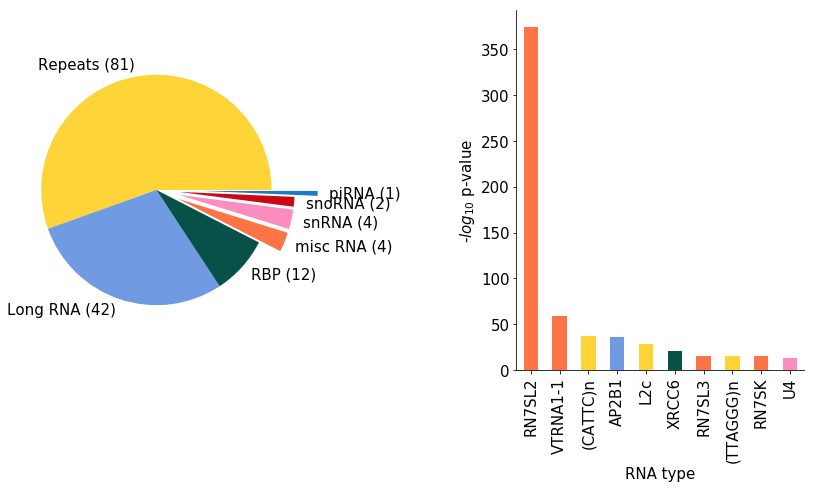

In [110]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks.assign(merged_type=lambda d: d["anti_merged_type"]), ax, ce)
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.head(10)
anti_plot.plot\
    .bar('picked_RNA_anti', 'log10q', 
         color = ce.transform(anti_plot\
                               .anti_merged_type),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [ ]:
bam_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam'
ref_path = '/stor/work/Lambowitz/ref/hg19'
tracks = {'DNase I': bam_path + '/unfragmented.bam',
         'NaOH': bam_path + '/alkaline_hydrolysis.bam',
         'sncRNA': ref_path + '/new_genes/sncRNA_viz.bed',
         'Protein': ref_path + '/new_genes/genes.bed12.bed'}
genome = ref_path + '/genome/hg19_genome.fa'

def color_func(interval):
    return 'salmon' if get_strand(interval.read) == '+' else 'steelblue'

regions = 'chr14:50329268-50329569'
matches = re.search('(chr[0-9XY]+):([0-9]+)-([0-9]+)', regions)
chrom, start, end = matches.groups()

viz = genomeview.visualize_data(tracks, chrom, int(start)-400, int(end)+400, genome)
for track in ['DNase I', 'NaOH']:
    tr = genomeview.get_one_track(viz, track)
    tr.color_fn = color_func
    if track == "DNase I":
        tr.row_height = 0.02

viz

In [113]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr10',57358980,57359246)

'CATTTATGTGGCAAAATAGTGAGAAGATTCATTAGTAGCAGTGACAAGCCTACGGAGGCTGGTGATAGCTGATTGTCCAAGGTAGAATTTTAGTTCAACTTTAAACTTAACCTACAGAATTACTTAATCCTCCTGTAAGTTTAACTGTTAAAGGGGGACGGATCTTCAGATACTAGAAAATAACCGTCCTATAGAGAGTAAAAGATTTTACCACCATAATTGGCCTAAAAGCAGCCACCAATTAAGAAAGCGTTTAAGCTCAACAT'

In [132]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df)\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8, s=True, wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(81, 28)

In [150]:
intron_df.columns

Index(['chrom', 'start', 'end', 'peakname', 'score', 'strand', 'fc', 'log10p',
       'log10q', 'pileup', 'gname', 'gstrand', 'gtype', 'gid',
       'picked_RNA_anti', 'picked_type_anti', 'picked_RNA_sense',
       'picked_type_sense', 'pvalue', 'merged_type', 'FDR', 'is_sense',
       'intron_chrom', 'intron_start', 'intron_end', 'intron_gene',
       'intron_score', 'intron_strand'],
      dtype='object')

In [169]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []

for i, intron in intron_df.query('pileup >=3').iterrows():
    intron_seq = fa.fetch(intron['chrom'], intron['intron_start'] - 1, intron['intron_end'])
    intron_seq = intron_seq if intron['strand'] == "+" else reverse_complement(intron_seq)
    seqs.append(intron_seq)
    if intron_seq == "GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTCCTGCCCCTCAGCCTCACCTGTGTGGCCTCCTCTCCTCCACACAG":print(intron)
    ss_dinucleotide[intron_seq[:2] + ':' + intron_seq[-2:]] += 1
    ss_dinucleotide_seq[intron_seq[:2] + ':' + intron_seq[-2:]].append((intron['chrom'] + ':' +\
                                                                        str(intron['intron_start']) + '-'+\
                                                                       str(intron['intron_end'])))
#    if 'DOCK6' in intron['gname']  :
#        break

chrom                                                            chr16
start                                                         15027134
end                                                           15027223
peakname                                     unfragmented.fwd_peak_911
score                                                              515
strand                                                               +
fc                                                             21.0599
log10p                                                         57.0113
log10q                                                          51.574
pileup                                                              21
gname                                             RP11-958N24.1,NPIPA1
gstrand                                                            +,+
gtype                transcribed_unprocessed_pseudogene,protein_coding
gid                          ENSG00000183458.13_4,ENSG00000183426.16_3
picked

In [161]:
ss_dinucleotide

defaultdict(int, {'GT:AG': 30})

In [168]:
from collections import Counter
Counter(seqs)

Counter({'GTAAGGAGGGGGATGAGGGGTCATATCTCTTCTCAGGGAAAGCAGGAGCCCTTCAGCAGGGTCAGGGCCCCTCATCTTCCCCTCCTTTCCCAG': 1,
         'GTAGAGAGGGCAGGGTGGGCCTAGGGTGGCTGGGGATGCCAGGAGGGGCTCCTCCTCCCTCCACTCCTGCCATCCCATGACGCGCCTCCTCTCTCACGCAG': 1,
         'GTAGGAGTGGGCGTGGGCAGGGTGGGCATGGCATGGATGGAAGGCGGAGCAATGTTGACATCACTGATGGCCACCCCTCTCCTGCAG': 1,
         'GTAGGATGATGGGGTCACGGACCAGGTCAGGGCTCACTCCCCACTGCCAGTTCCCCAAATGCTGAGTTGGCTCCTGCCCTGTCTCCTCCAG': 1,
         'GTAGGCCAGCGCCTTTGCAGGGGTCTGTGGTAGAAGGGAGACGCGGCCTCATCCGCAGCATCCTCATCCACAGCATCCTCACGGTGCCTGCCCCCAG': 1,
         'GTAGGTGGAGGGTGCAGGGGTCGGGGGCAGGGGCCCGGGGGCAGCCTGGACTCTGCTCATGTGCCCACCTGGCCACTCACCTGCAG': 1,
         'GTGAGAGGACAGCTGGGGTGGGGGCCCTTCTCCCCTTCTAATACCCACCCTGCTTTCTCCCTGTAAGCATGGCCTCCACCTCTCGTCCCCTACTGGCCTCAAGCCTCCACTGCTGTCCTCCCACAG': 1,
         'GTGAGCAGCGGGGAGGGACGGGGAGCTGGAGGGGAGCCGAGAGTATCGAGCAGGCACTGAAGCTGCGGTCCCTCCCTCTCCTCAG': 1,
         'GTGAGCTGGGGGAGGGCAGGAGGCTGGGTCCCACTCCCCCAGCCACGATGGAGGCTGGCCGACGTTTAACCTGGCTTTTCCTTTCCTCTCTGCTCA

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
res.res2d

In [ ]:
peaks.query('merged_type	=="piRNA"')

In [ ]:
import mappy as mp

mt = 0
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
mts = []
piRNA = peaks.query('merged_type == "piRNA"').reset_index()
for i, row in piRNA.iterrows():
    seq = fa.fetch(row['chrom'], row['start'], row['end'])
    seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
    alns = aligner.map(seq)
    try:
        aln = next(alns)
        mt += 1
        mts.append('MT')
        #print(aln.cigar_str)
    except StopIteration:
        #print(row)
        mts.append('no')
        pass


print(mt, i)

In [112]:
peak_df.query('merged_type == "piRNA"').sort_values('pileup', ascending=False)

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense
158,chr9,5093671,5093964,unfragmented.fwd_peak_2599,350,+,13.93777,40.09976,35.06981,37.0,...,"piRNA,piRNA,protein_coding,protein_coding,prot...","piRNA,piRNA,ENSG00000096968.13_3,NM_001322194....",.,.,piR-hsa-1847,piRNA,7.947673e-41,piRNA,1.305554e-38,Sense
712,chr7,22549930,22551681,unfragmented.rvs_peak_19178,60,-,4.05031,10.23191,6.07022,14.0,...,"LINE,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,proce...","L1,LARP4,RBM22,PPIL4,YBX3,YBX3,YBX3,YBX3,YBX3,...",.,.,piR-hsa-20701,piRNA,5.862596e-11,piRNA,2.073844e-09,Sense
267,chr7,141504962,141505178,unfragmented.rvs_peak_20103,180,-,8.27379,23.02750,18.06352,12.0,...,"piRNA,piRNA","piRNA,piRNA",.,.,piR-hsa-1847,piRNA,9.386420e-24,piRNA,9.239823e-22,Sense
422,chr19,1272776,1273020,unfragmented.fwd_peak_1143,108,+,6.00430,15.65481,10.87445,8.0,...,"protein_coding,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP...","NM_001300815.1,FAM120A,UPF1,GPKOW,TROVE2,GPKOW...",piR-hsa-7551,piRNA,piR-hsa-21688,piRNA,2.214063e-16,piRNA,1.392158e-14,Sense
692,chr1,96912715,96913488,unfragmented.fwd_peak_111,63,+,4.45869,10.57947,6.30960,8.0,...,"processed_pseudogene,piRNA,piRNA,RBP,RBP,RBP,p...","ENSG00000228502.1_3,piRNA,piRNA,YBX3,YBX3,YBX3...",.,.,piR-hsa-16348,piRNA,2.633480e-11,piRNA,9.776236e-10,Sense
603,chr7,137198563,137198850,unfragmented.fwd_peak_2461,72,+,5.17036,11.75570,7.25990,7.0,...,"piRNA,piRNA,processed_pseudogene,piRNA,piRNA,p...","piRNA,piRNA,ENSG00000279483.2_3,piRNA,piRNA,EN...",piR-hsa-27278,piRNA,piR-hsa-15610,piRNA,1.755092e-12,piRNA,7.488489e-11,Sense
786,chr6,153603463,153603891,unfragmented.rvs_peak_18814,55,-,3.89383,9.94736,5.52830,7.0,...,"processed_pseudogene,RBP,RBP,RBP,RBP,RBP,RBP,R...","ENSG00000218426.5_4,IGF2BP2,UCHL5,SND1,DDX6,YB...",RP11-306O13.1,lincRNA,piR-hsa-30977,piRNA,1.128860e-10,piRNA,3.507071e-09,Sense
1150,chr12,104659057,104659669,unfragmented.fwd_peak_611,46,+,3.67369,9.08555,4.60939,5.0,...,"RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RB...","GEMIN5,METAP2,DHX30,DDX6,DDX3X,SND1,YBX3,DDX3X...",RP11-818F20.5,antisense,piR-hsa-23558,piRNA,8.212020e-10,piRNA,1.934019e-08,Sense
1513,chrX,147134098,147134234,unfragmented.fwd_peak_2793,33,+,3.23921,7.55269,3.31093,4.0,...,"processed_pseudogene,piRNA,piRNA,piRNA,piRNA","ENSG00000219507.4_3,piRNA,piRNA,piRNA,piRNA",.,.,piR-hsa-12730,piRNA,2.800980e-08,piRNA,5.004633e-07,Sense
1518,chr5,177482654,177483092,unfragmented.fwd_peak_2158,32,+,3.47919,7.39330,3.29210,4.0,...,"processed_pseudogene,RBP,piRNA,piRNA,RBP,RBP,R...","ENSG00000218227.3_4,DDX3X,piRNA,piRNA,DDX3X,YB...",.,.,piR-hsa-10496,piRNA,4.042965e-08,piRNA,5.417255e-07,Sense
